In [1]:
import numpy as np 
import pandas as pd
#import plotly.plotly as py
#from plotly.offline import init_notebook_mode,iplot
#init_notebook_mode(connected=True)
import plotly.graph_objs as go
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
#%matplotlib inline
from wordcloud import WordCloud
import string
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score,roc_curve,make_scorer
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import os
import scikitplot as skplt
import seaborn as sns
import time
from catboost import CatBoostClassifier, Pool, MetricVisualizer

/home/renat/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.

/home/renat/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.

/home/renat/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



In [2]:
import pretty_errors

In [2]:
data=pd.read_csv('df_train.csv')
data = data.dropna()

In [3]:
X = data['text']
Y = data['target']

train_X , val_X, train_y, val_y = train_test_split(X, Y, test_size=0.1, random_state=42)

In [4]:
print(train_X.shape)
print(val_X.shape)
print(train_y.shape)
print(val_y.shape)

(7210,)
(802,)
(7210,)
(802,)


In [5]:
cv=CountVectorizer(ngram_range=(1,3), analyzer='word')
train_X_cv=cv.fit_transform(train_X.values)
val_X_cv=cv.transform(val_X.values)

In [6]:
tsvd = TruncatedSVD(n_components=50, random_state=42)
train_X_svd = tsvd.fit_transform(train_X_cv)
val_X_svd = tsvd.transform(val_X_cv)
tsne = TSNE(n_components=2, random_state=42)
train_X_tsne = tsne.fit_transform(train_X_svd)

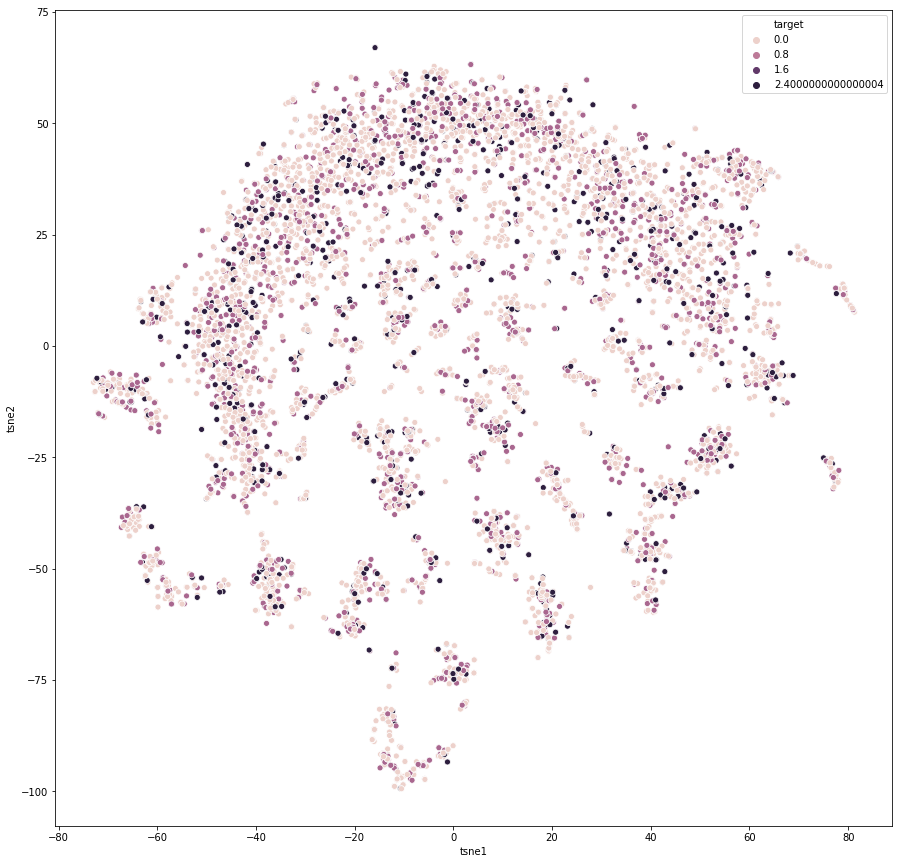

In [7]:
df = pd.DataFrame()
df["tsne1"] = pd.Series(train_X_tsne[:, 0])
df["tsne2"] = pd.Series(train_X_tsne[:, 1])
df["target"] = train_y
plt.figure(figsize=(15, 15))
sns.scatterplot(
    df["tsne1"], df["tsne2"], hue="target", data=df
)
plt.show()

In [8]:
data.target.value_counts()

0    4839
1    2087
2    1086
Name: target, dtype: int64

In [9]:
label = train_y.unique().tolist()

In [10]:
label

[0, 1, 2]

In [11]:
def get_model(model, train_X, train_y, val_X):
    model.fit(train_X, train_y)
    pred_probs = model.predict_proba(val_X)
    pred_train = model.predict(train_X)
    pred_val = model.predict(val_X)
    score_train = f1_score(train_y, pred_train, average=None)
    score_val = f1_score(val_y, pred_val, average=None)
    return (
        pred_probs,
        pred_train,
        pred_val,
        score_train,
        score_val,
    )


def get_confusion_matrix(val_y, pred, title):
    cm = confusion_matrix(val_y, pred, labels=label)
    #plt.figure(figsize=(15, 15))
    #sns.heatmap(cm, annot=True)
    #plt.title(title)
    #plt.ylabel("True labels")
    #plt.xlabel("Predicted labels")
    #plt.show()
    fig = plt.figure(figsize=(15, 15))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cbar=False, fmt='g'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix' + title); 
    ax.xaxis.set_ticklabels(label);
    ax.yaxis.set_ticklabels(label);


def get_roc_curve(val_y, pred_probs, title):
    #plt.figure(figsize=(15, 15))
    plt.title(title)
    skplt.metrics.plot_roc(val_y, pred_probs, figsize=(15, 15))

In [12]:
import xgboost as xgb

In [13]:
models = [
    LogisticRegression(random_state=42),
    MultinomialNB(),
    DecisionTreeClassifier(random_state=42),
    AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=3),
        n_estimators=100,
        learning_rate=0.1,
        random_state=42,
    ),
    RandomForestClassifier(
        n_estimators=500, max_depth=5, random_state=42
    ),
    XGBClassifier(random_state=42),
    CatBoostClassifier(iterations=100,
    learning_rate=0.01,
    depth=5,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    leaf_estimation_method='Newton'),
#     xgb.XGBClassifier(max_depth=5, objective='multi:softprob', n_estimators=1000, 
#                         num_classes=5)
]
model_names = [
#    "xgboost"
    "LR",
    "Multinomial NB",
    "DTC",
    "ABC",
    "RFC",
    "XGBC",
    "catboost"
]

In [14]:
pred_probs = {}
pred_train = {}
pred_val = {}
score_train = {}
score_val = {}

for i in range(len(models)):
    pred_probs[model_names[i]], pred_train[
        model_names[i]
    ], pred_val[model_names[i]], score_train[
        model_names[i]
    ], score_val[
        model_names[i]
    ] = get_model(
        models[i], train_X_cv, train_y, val_X_cv
    )


scl = StandardScaler()
train_X_scl_cv = scl.fit_transform(train_X_svd)
val_X_scl_cv = scl.transform(val_X_svd)
pred_probs["SVC"], pred_train["SVC"], pred_val[
    "SVC"
], score_train["SVC"], score_val["SVC"] = get_model(
    SVC(probability=True, random_state=42),
    train_X_scl_cv,
    train_y,
    val_X_scl_cv,
)

0:	learn: 0.6226075	total: 658ms	remaining: 1m 5s
1:	learn: 0.6223301	total: 1.23s	remaining: 1m
2:	learn: 0.6223301	total: 1.8s	remaining: 58.3s
3:	learn: 0.6214979	total: 2.37s	remaining: 56.9s
4:	learn: 0.6223301	total: 2.94s	remaining: 56s
5:	learn: 0.6214979	total: 3.51s	remaining: 55s
6:	learn: 0.6214979	total: 4.09s	remaining: 54.3s
7:	learn: 0.6223301	total: 4.66s	remaining: 53.6s
8:	learn: 0.6214979	total: 5.23s	remaining: 52.9s
9:	learn: 0.6223301	total: 5.81s	remaining: 52.3s
10:	learn: 0.6223301	total: 6.39s	remaining: 51.7s
11:	learn: 0.6223301	total: 6.96s	remaining: 51.1s
12:	learn: 0.6221914	total: 7.54s	remaining: 50.5s
13:	learn: 0.6223301	total: 8.11s	remaining: 49.8s
14:	learn: 0.6214979	total: 8.69s	remaining: 49.3s
15:	learn: 0.6223301	total: 9.27s	remaining: 48.7s
16:	learn: 0.6214979	total: 9.85s	remaining: 48.1s
17:	learn: 0.6214979	total: 10.4s	remaining: 47.5s
18:	learn: 0.6214979	total: 11s	remaining: 47s
19:	learn: 0.6223301	total: 11.6s	remaining: 46.4s
20

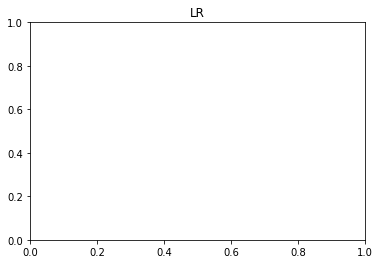

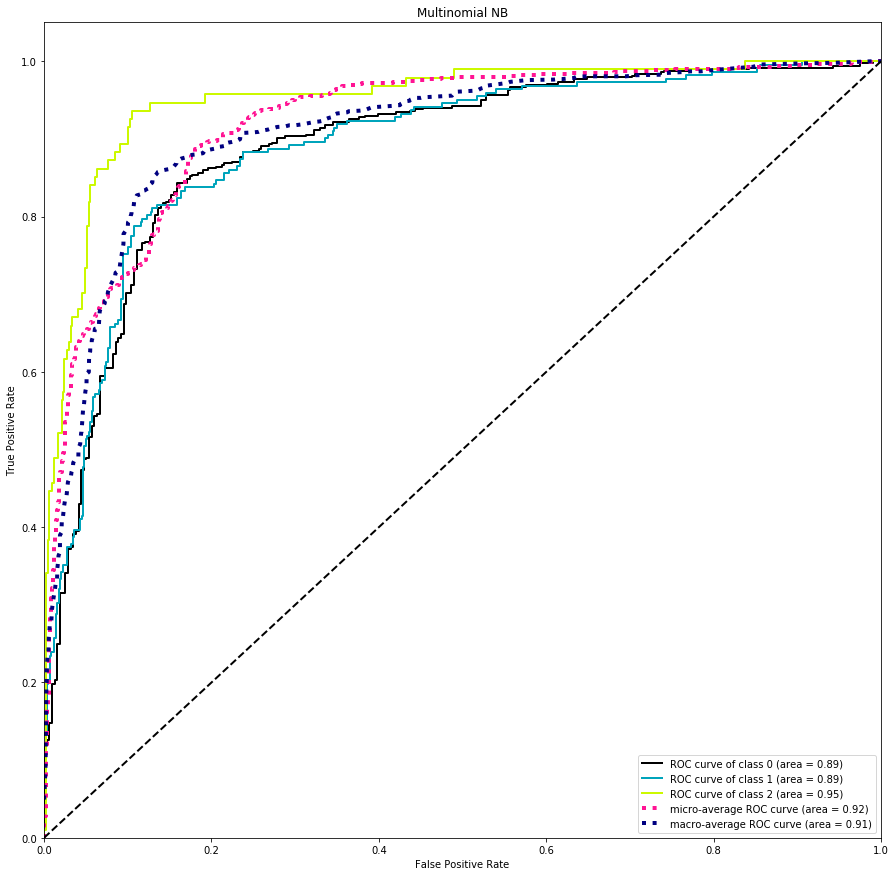

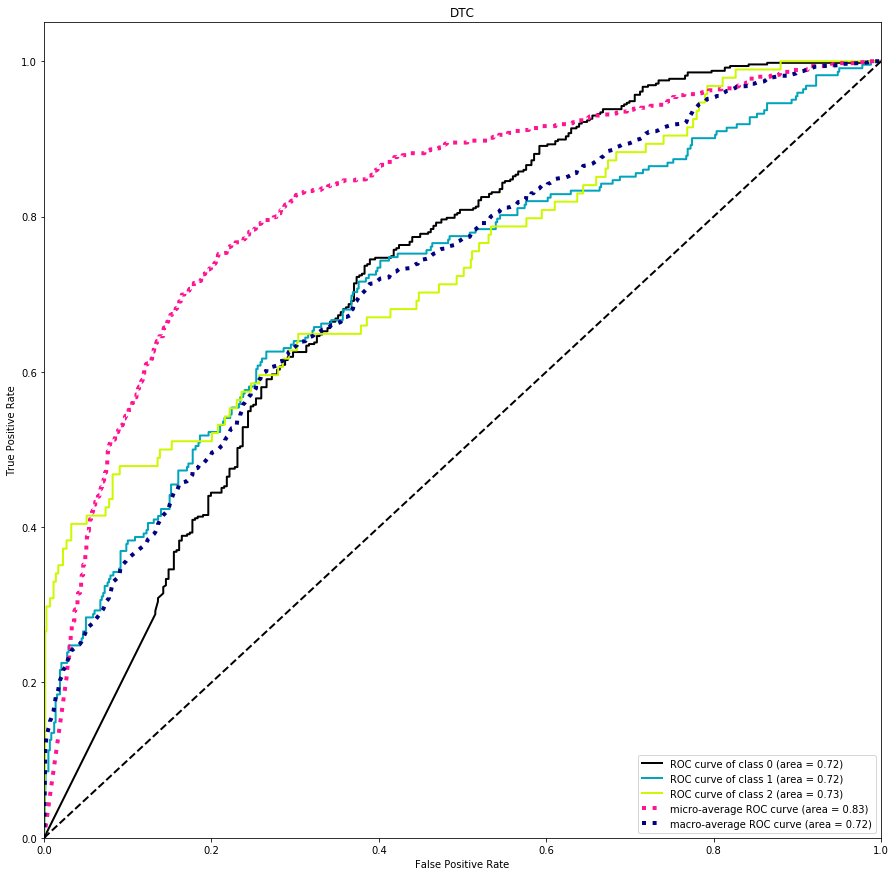

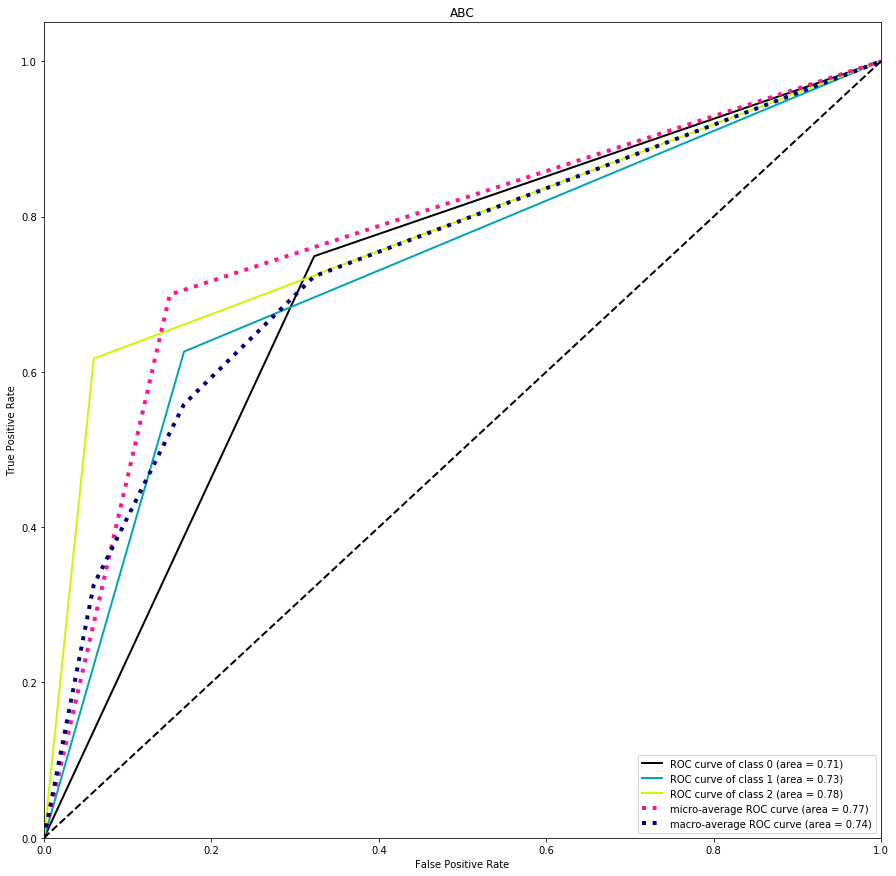

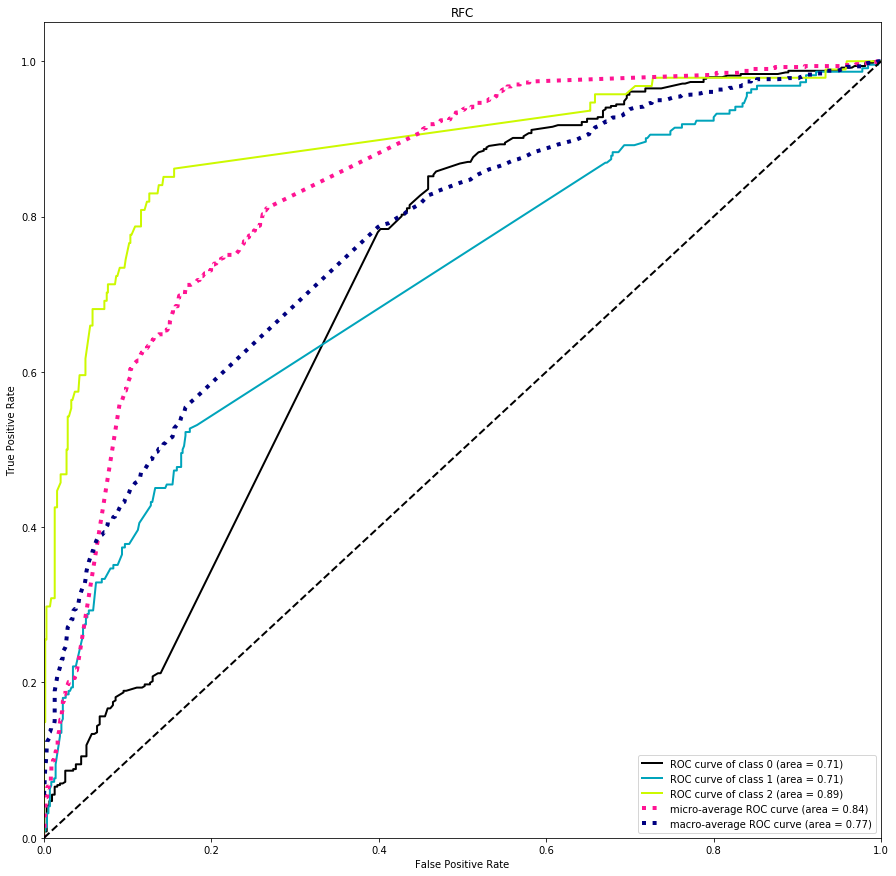

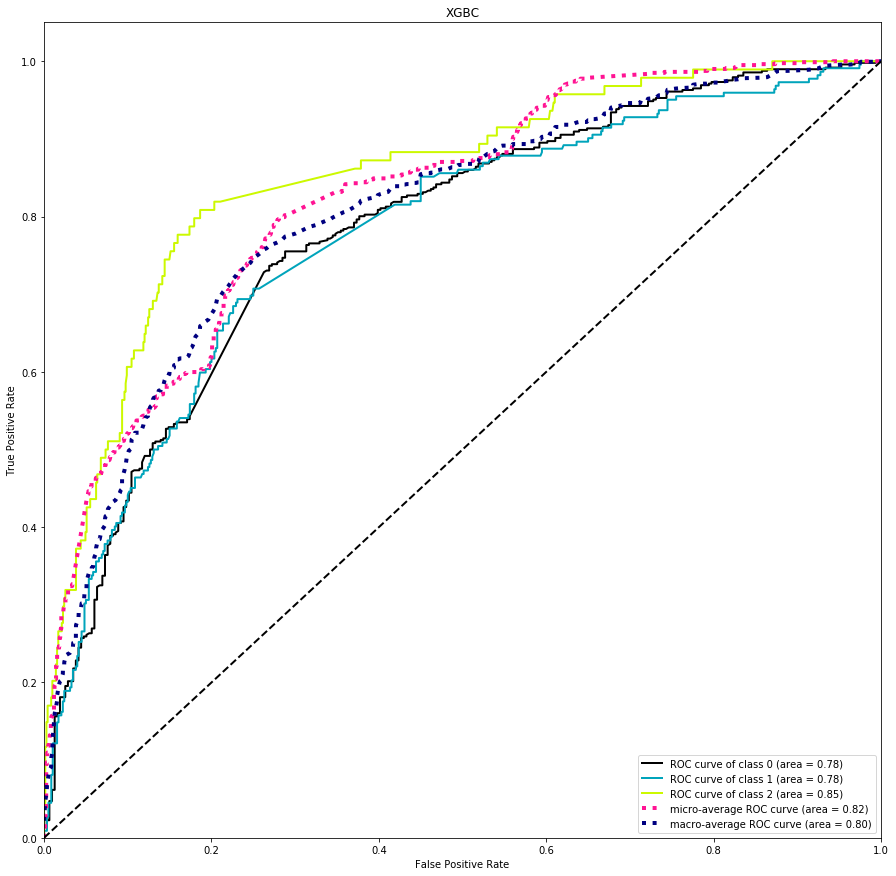

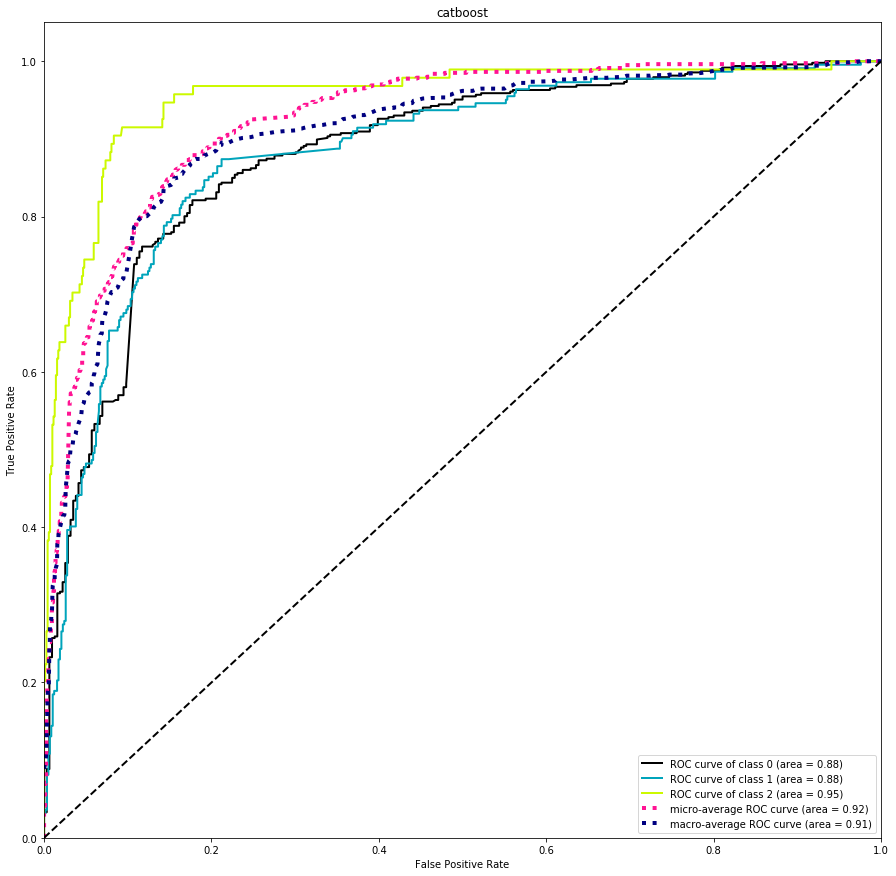

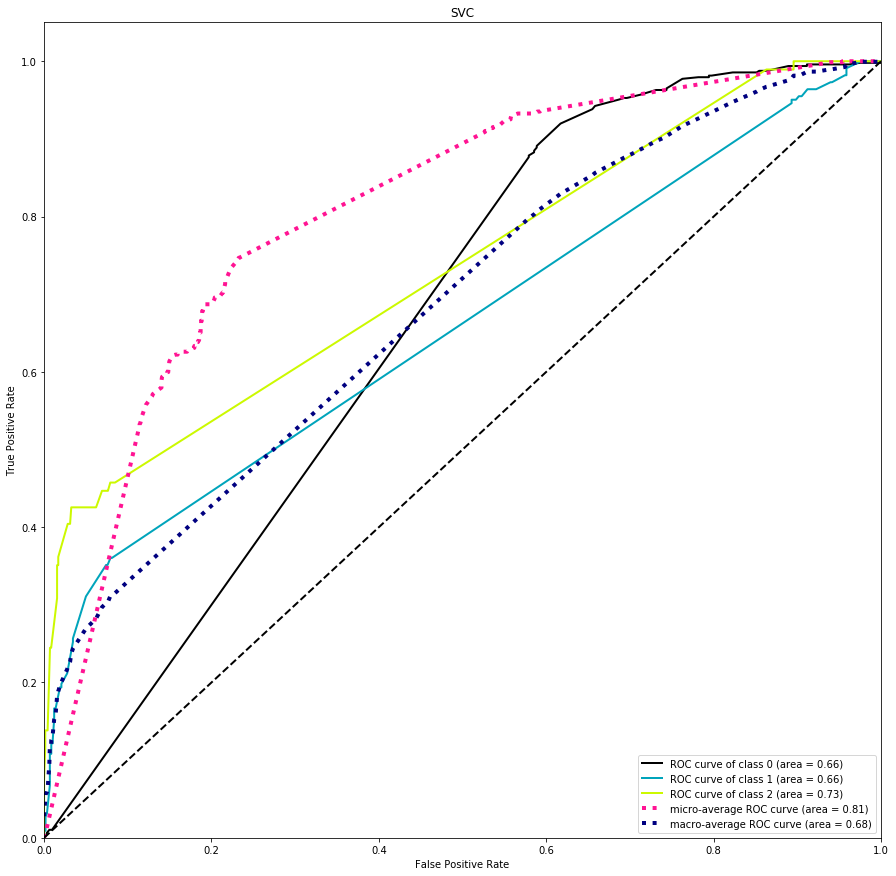

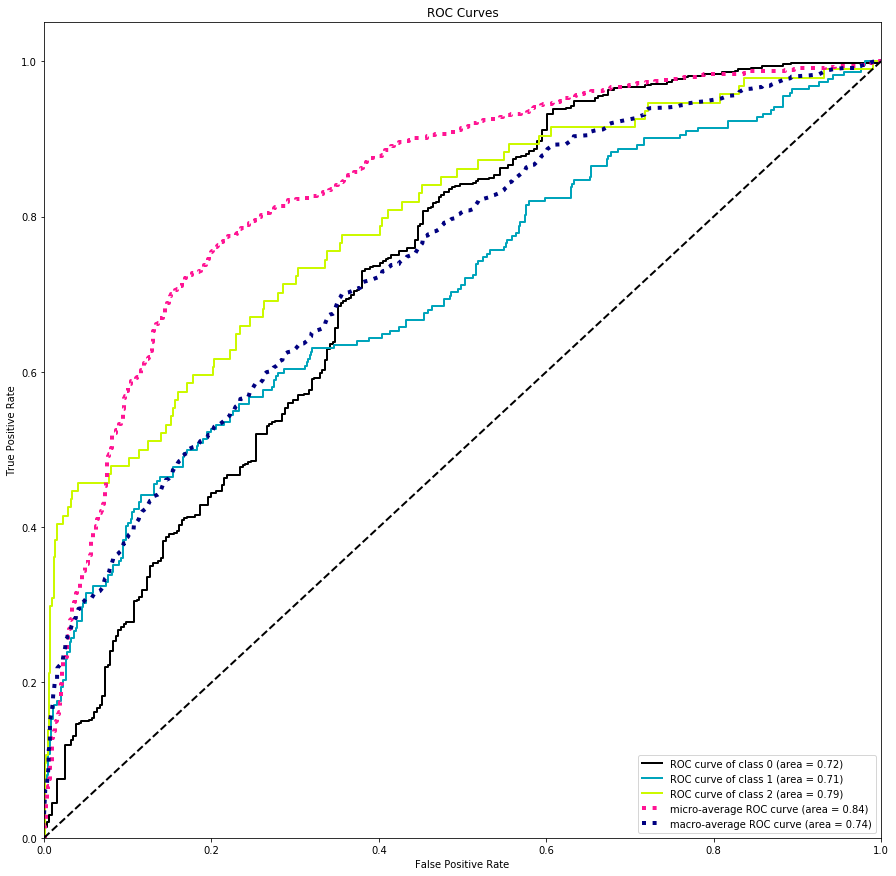

In [15]:
for model,probs in pred_probs.items():
    get_roc_curve(val_y,probs,model)

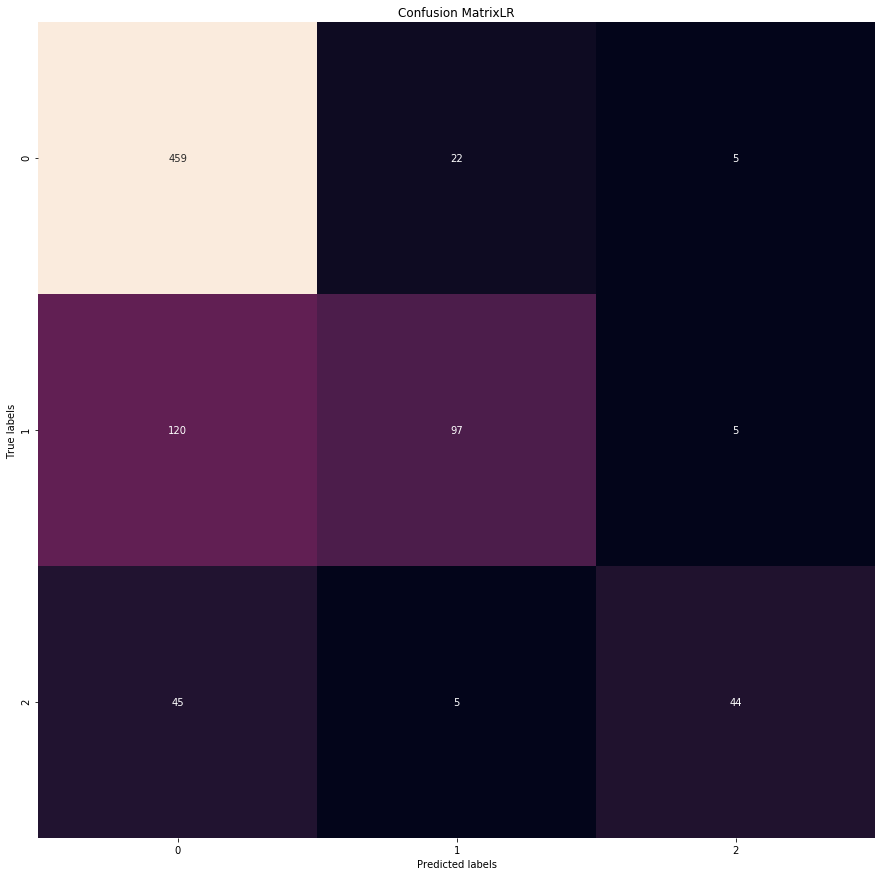

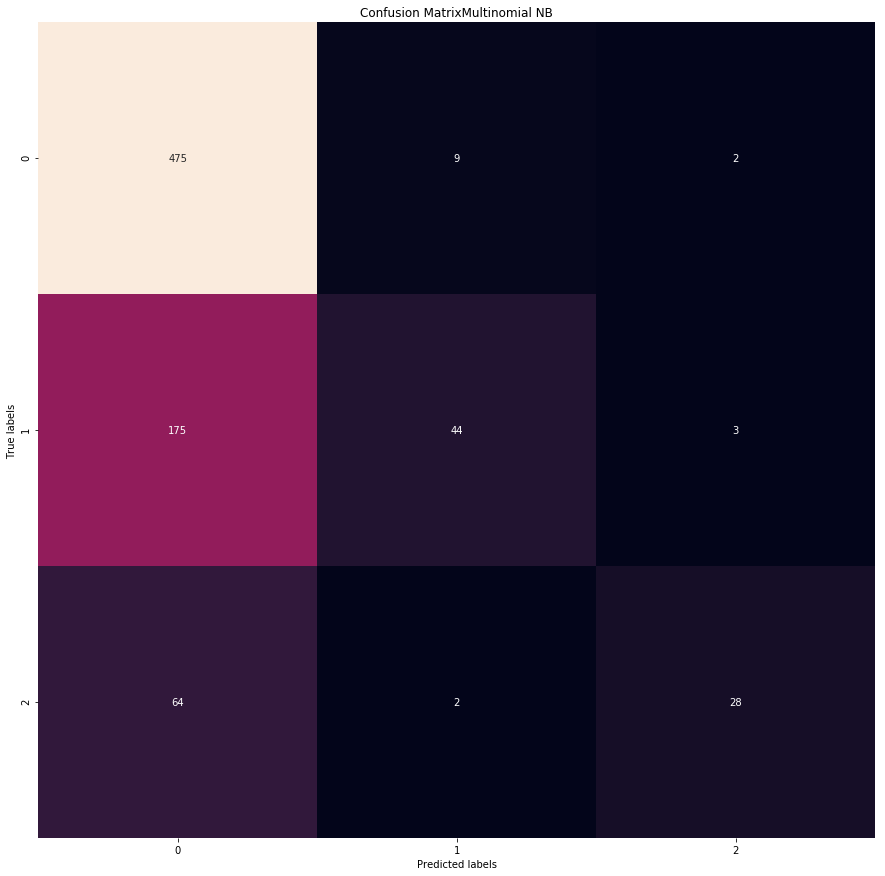

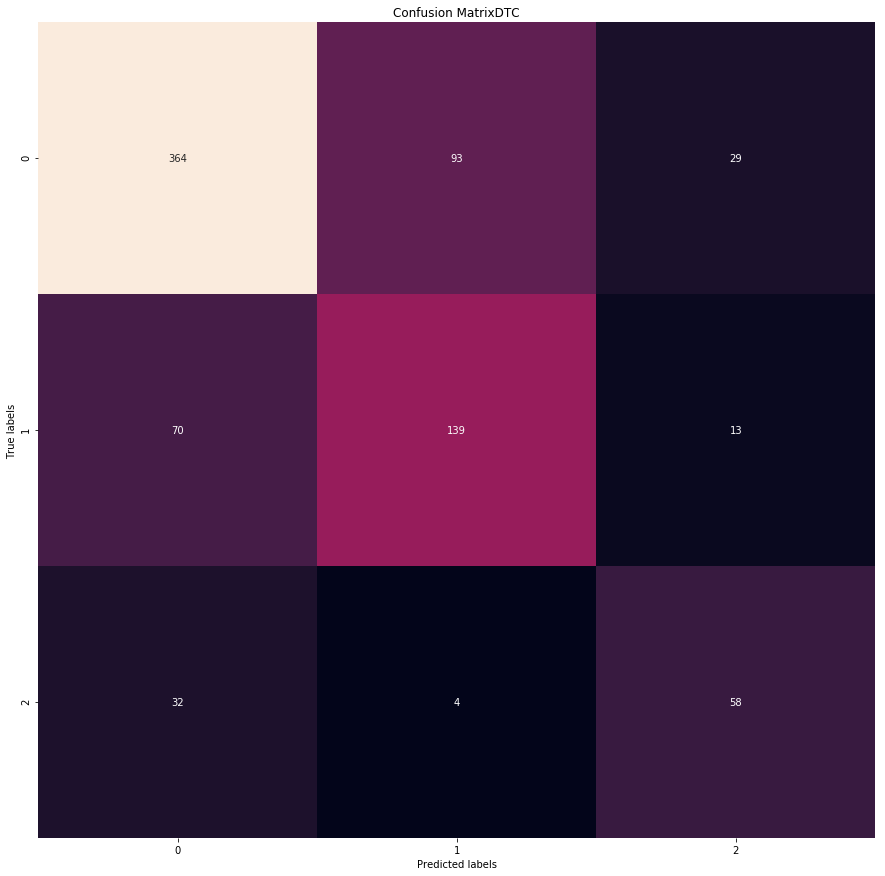

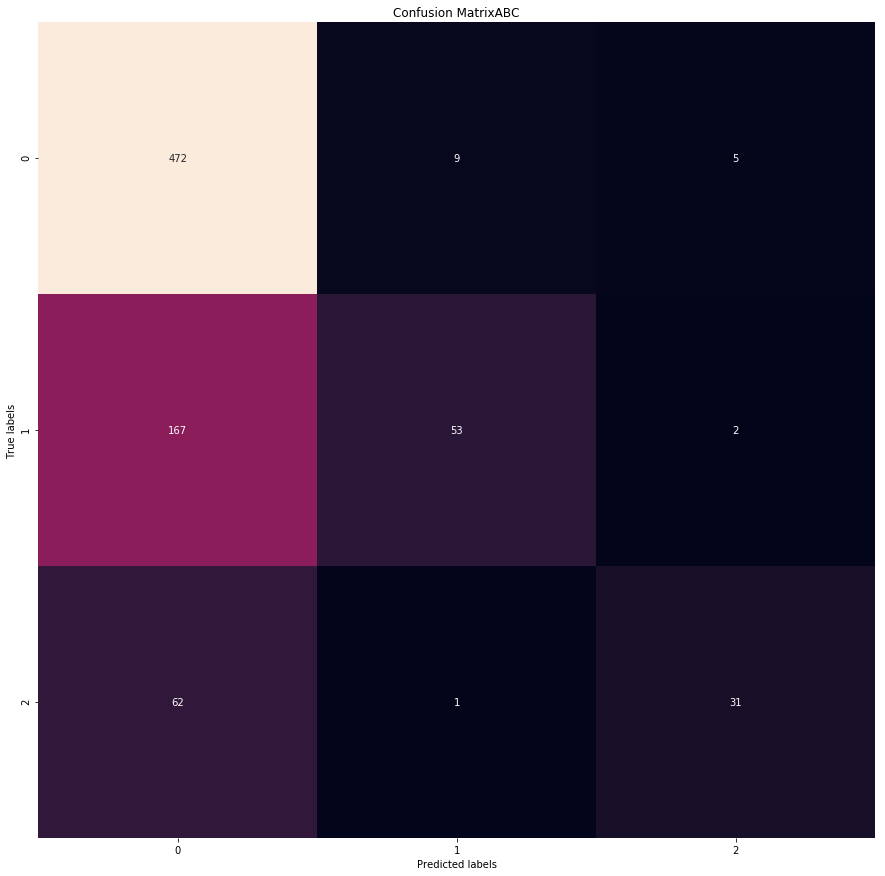

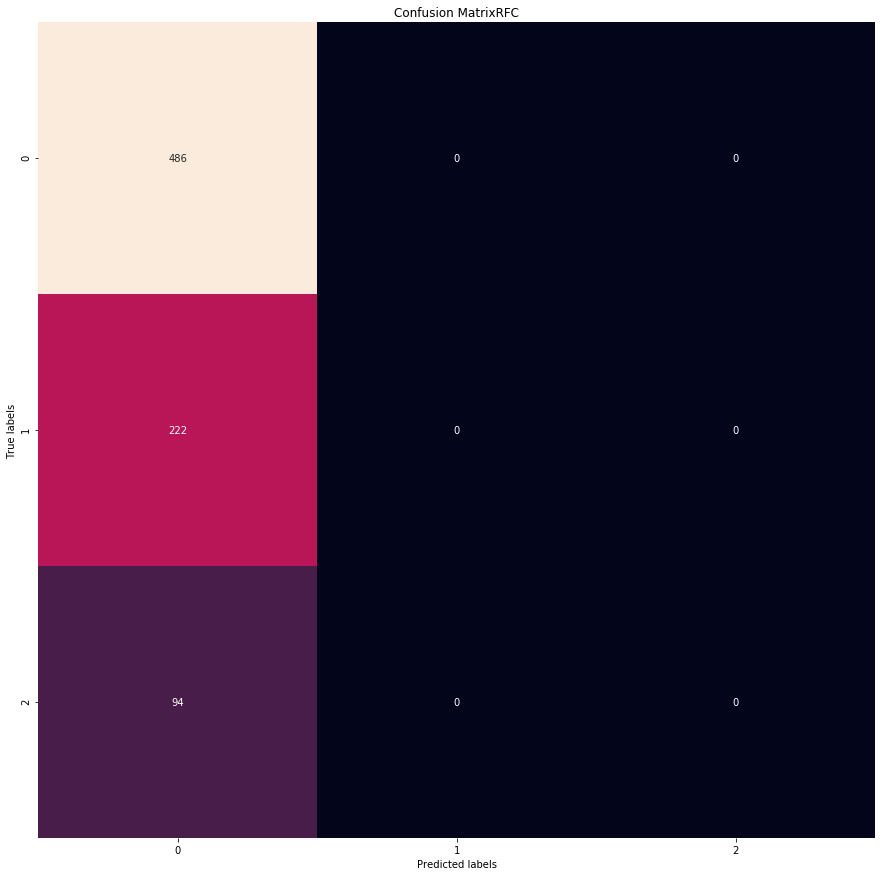

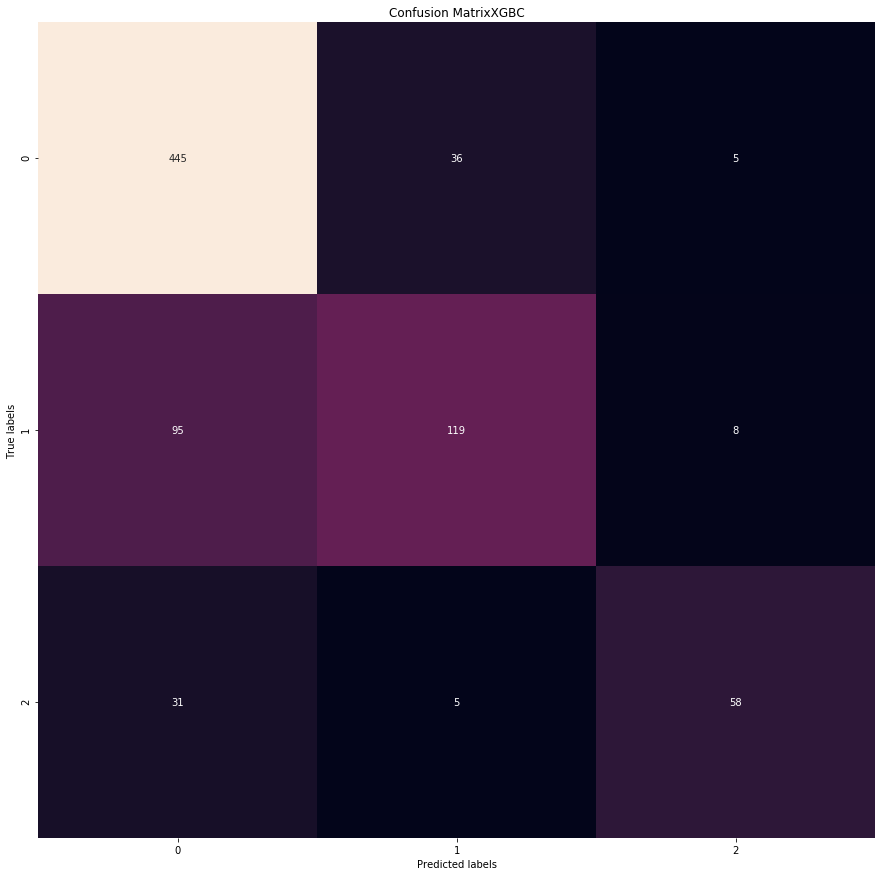

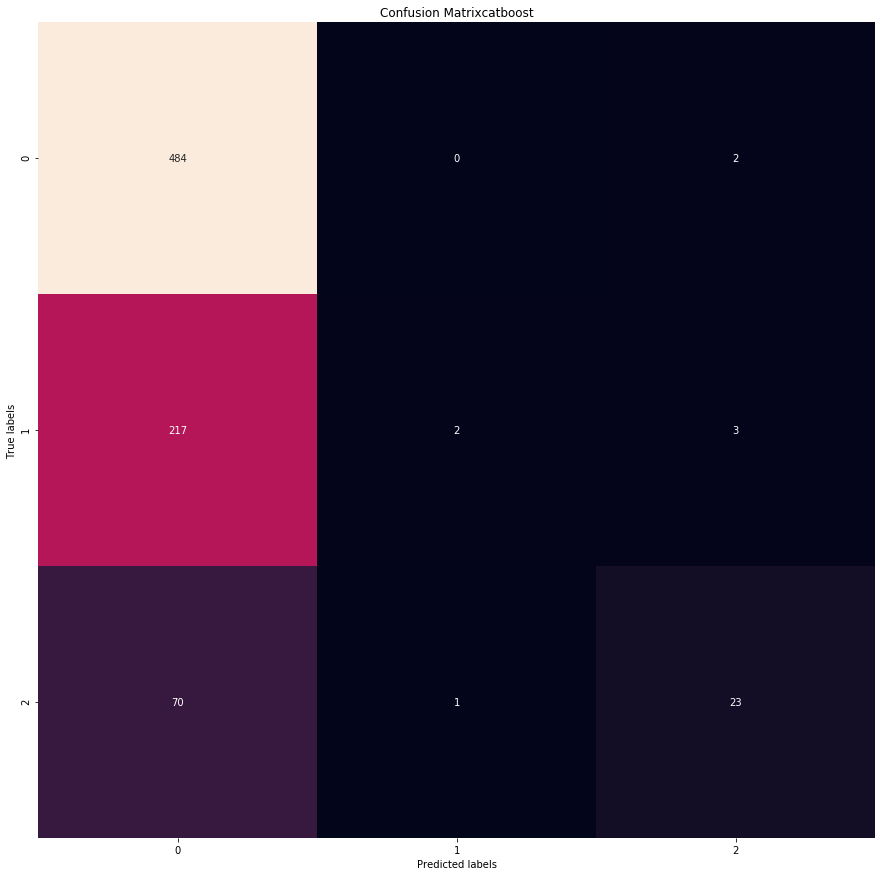

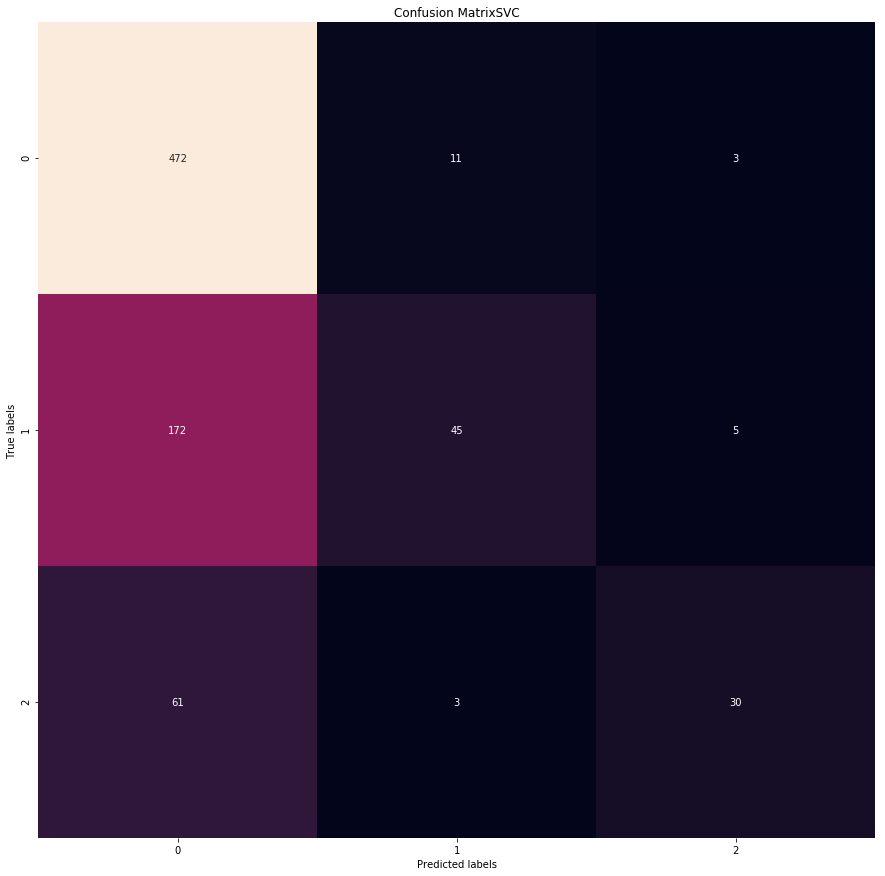

In [16]:
for model,pred in pred_val.items():
    get_confusion_matrix(val_y,pred,model)